# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import imblearn.over_sampling as oversampling

We will prepare the dataset the same way as the old one, but with a different target.

In [2]:
df = pd.read_parquet("../diabetes_dataset.parquet")
df.head()

,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,...,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,...,41,160,145,136,236,6.36,8.18,29.600000,Type 2,1
1,48,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,...,55,50,30,93,150,2.00,5.63,23.000000,No Diabetes,0
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,...,66,99,36,118,195,5.07,7.51,44.700001,Type 2,1
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,...,50,79,140,139,253,5.28,9.03,38.200001,Type 2,1
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,...,52,125,160,137,184,12.74,7.20,23.500000,Type 2,1


In [3]:
df["diabetes_risk_score"].describe()

count    100000.000000
mean         30.222361
std           9.061428
min           2.700000
25%          23.799999
50%          29.000000
75%          35.599998
max          67.199997
Name: diabetes_risk_score, dtype: float64

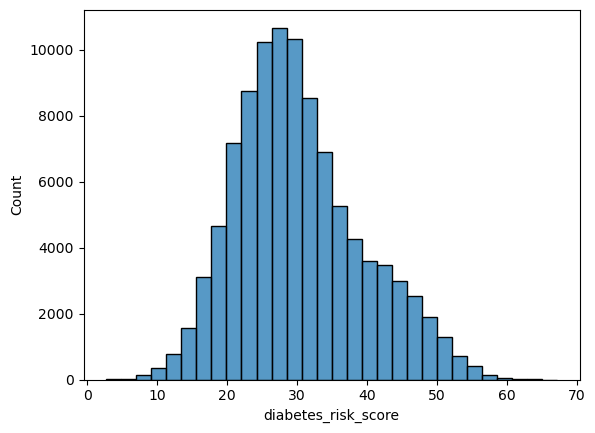

In [4]:
sns.histplot(df["diabetes_risk_score"], bins=30);

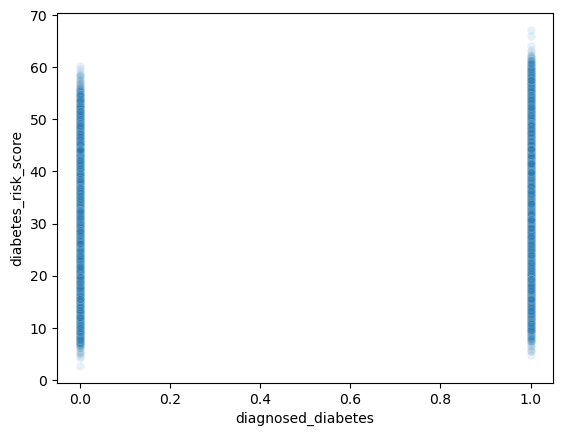

In [5]:
sns.scatterplot(data=df, x="diagnosed_diabetes", y="diabetes_risk_score", alpha=0.1);

In [6]:
df[df["diabetes_risk_score"] > 50].shape

(2584, 31)

In [7]:
df[df["diabetes_risk_score"] < 20].shape

(10920, 31)

The data will be imbalanced if we split it this way, so we will have to deal with that.

We will first do the same preparation as we did earlier.

In [8]:
binning_dict = {
    # Age categories based on common demographic groupings
    "age": {
        "bins": [18, 30, 40, 50, 60, 70, 80, 91],
        "labels": ["18-29","30-39","40-49","50-59","60-69","70-79","80+"]
    },
    # Diet score categories created arbitrarily for this dataset
    "diet_score": {
        "bins": [0, 4, 7, 9, 10],
        "labels": ["Poor","Fair","Good","Excellent"]
    },
    # The National Sleep Foundation recommends 7-9 hours of sleep for adults aged 18-64 and 7-8 hours for those 65 and older
    "sleep_hours_per_day": {
        "bins": [0, 5, 7, 9, 11],
        "labels": ["Very_Short","Short","Normal","Long"]
    },
    # Screen time categories created arbitrarily for this dataset
    "screen_time_hours_per_day": {
        "bins": [0, 2, 5, 8, 17],
        "labels": ["Low","Moderate","High","Very_High"]
    },
    # BMI categories based on WHO standards; The dataset does not contain values above 40, which would represent Obese III
    "bmi": {
        "bins": [0, 18.5, 25, 30, 35, 40],
        "labels": ["Underweight","Normal","Overweight","Obese_I","Obese_II"]
    },
    # Blood pressure categories based on American Heart Association guidelines; The dataset does not contain values above 180, which would represent Hypertensive crisis
    "systolic_bp": {
        "bins": [0, 120, 130, 140, 180],
        "labels": ["Normal","Elevated","HTN_Stage_1","HTN_Stage_2"]
    },
    # Diastolic blood pressure categories based on American Heart Association guidelines; The dataset does not contain values above 120, which would represent Hypertensive crisis
    "diastolic_bp": {
        "bins": [0, 80, 90, 120],
        "labels": ["Normal","HTN_Stage_1","HTN_Stage_2"]
    },
    # Heart rate categories based on common clinical guidelines
    "heart_rate": {
        "bins": [0, 60, 100, 120],
        "labels": ["Bradycardia","Normal","Tachycardia"]
    },
    # Cholesterol categories based on American Heart Association guidelines
    "cholesterol_total": {
        "bins": [0, 200, 240, 400],
        "labels": ["Desirable","Borderline_high","High"]
    },
    # HDL cholesterol categories based on American Heart Association guidelines
    "hdl_cholesterol": {
        "bins": [0, 40, 60, 120],
        "labels": ["Low","Normal","High"]
    },
    # LDL cholesterol categories based on American Heart Association guidelines
    "ldl_cholesterol": {
        "bins": [0, 100, 130, 160, 190, 300],
        "labels": ["Optimal","Near_optimal","Borderline_high","High","Very_high"]
    },
    # Triglycerides categories based on American Heart Association guidelines; The dataset does not contain values above 344. Values above 500 would represent Very high
    "triglycerides": {
        "bins": [0, 150, 200, 500],
        "labels": ["Normal","Borderline_high","High"]
    },
    # Insulin level categories based on common clinical reference ranges
    "insulin_level": {
        "bins": [0, 2, 25, 50],
        "labels": ["Low","Normal","High"]
    },
    # -1 to include zero alcohol consumption
    "alcohol_consumption_per_week": {
        "bins": [-1, 0, 2, 5, 11],
        "labels": ["None","Light","Moderate", "Heavy"]
    },
    # WHO recommends at least 150 minutes of moderate physical activity per week for adults
    "physical_activity_minutes_per_week": {
        "bins": [-1, 30, 100, 150, 300, 3000],
        "labels": ["Sedentary","Light","Moderate","Active","Very Active"]
    }
}

for col, config in binning_dict.items():
    df[col] = pd.cut(df[col], bins=config["bins"], labels=config["labels"], right=False)

df.head()

,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,...,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,50-59,Male,Asian,Highschool,Lower-Middle,Employed,Never,Light,Active,Fair,...,Normal,High,Normal,136,236,Normal,8.18,29.600000,Type 2,1
1,40-49,Female,White,Highschool,Middle,Employed,Former,Light,Moderate,Fair,...,Normal,Optimal,Normal,93,150,Normal,5.63,23.000000,No Diabetes,0
2,60-69,Male,Hispanic,Highschool,Middle,Unemployed,Never,Light,Light,Fair,...,High,Optimal,Normal,118,195,Normal,7.51,44.700001,Type 2,1
3,70-79,Female,Black,Highschool,Low,Retired,Never,Light,Light,Poor,...,Normal,Optimal,Normal,139,253,Normal,9.03,38.200001,Type 2,1
4,40-49,Male,White,Graduate,Middle,Retired,Never,Light,Moderate,Good,...,Normal,Near_optimal,Borderline_high,137,184,Normal,7.20,23.500000,Type 2,1


In [9]:
df_eng = pd.get_dummies(
    df.copy(

    ).drop(
        columns=["diagnosed_diabetes", "diabetes_stage"]
    ).assign(
        glucose_fasting_times_hba1c=df["glucose_fasting"] * df["hba1c"],
        glucose_postprandial_times_hba1c=df["glucose_postprandial"] * df["hba1c"],
    ),
    drop_first=True,
    dtype=np.uint8
)

df_eng.head()

,family_history_diabetes,hypertension_history,cardiovascular_history,waist_to_hip_ratio,glucose_fasting,glucose_postprandial,hba1c,diabetes_risk_score,glucose_fasting_times_hba1c,glucose_postprandial_times_hba1c,...,hdl_cholesterol_Normal,hdl_cholesterol_High,ldl_cholesterol_Near_optimal,ldl_cholesterol_Borderline_high,ldl_cholesterol_High,ldl_cholesterol_Very_high,triglycerides_Borderline_high,triglycerides_High,insulin_level_Normal,insulin_level_High
0,0,0,0,0.89,136,236,8.18,29.600000,1112.479980,1930.480103,...,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0.80,93,150,5.63,23.000000,523.590027,844.500000,...,1,0,0,0,0,0,0,0,1,0
2,1,0,0,0.81,118,195,7.51,44.700001,886.180054,1464.450073,...,0,1,0,0,0,0,0,0,1,0
3,0,0,0,0.88,139,253,9.03,38.200001,1255.169922,2284.589844,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0.78,137,184,7.20,23.500000,986.399963,1324.799927,...,1,0,1,0,0,0,1,0,1,0


In [10]:
# df_eng["diabetes_risk_score"] = df_eng["diabetes_risk_score"].map(lambda x: 2 if x > 50 else (0 if x < 20 else 1))
# print(df_eng["diabetes_risk_score"].value_counts())
# df_eng.head()

Now let us deal with the imbalance.

In [11]:
# X_train, X_test, y_train, y_test = train_test_split(
#     df_eng.drop(columns=["diabetes_risk_score"]),
#     df_eng["diabetes_risk_score"],
#     test_size=0.2,
#     random_state=2025
# )

In [12]:
# n_low = np.sum(y_train == 0)
# n_medium = np.sum(y_train == 1)
# n_high = np.sum(y_train == 2)

# print(f"Low risk samples: {n_low}")
# print(f"Medium risk samples: {n_medium}")
# print(f"High risk samples: {n_high}")

In [13]:
# ratio = {0: round(n_low * 5), 1: n_medium, 2: round(n_high * 10)}

# smt = oversampling.SMOTE(sampling_strategy=ratio, random_state=2025)

# X_train_rs, y_train_rs = smt.fit_resample(X_train, y_train)

# print("After resampling:")
# print(y_train_rs.value_counts())

We will use this ratio later on in training.

In [ ]:
# df_eng.to_parquet("../diabetes_dataset_prepared_2.parquet")

The previous cells commented out, as the decision was made later on to use only two classes for convenience.

In [15]:
df_eng["diabetes_risk_score"] = df_eng["diabetes_risk_score"].map(lambda x: 1 if x >= 40 else 0)
print(df_eng["diabetes_risk_score"].value_counts())
df_eng.head()

diabetes_risk_score
0    84061
1    15939
Name: count, dtype: int64


,family_history_diabetes,hypertension_history,cardiovascular_history,waist_to_hip_ratio,glucose_fasting,glucose_postprandial,hba1c,diabetes_risk_score,glucose_fasting_times_hba1c,glucose_postprandial_times_hba1c,...,hdl_cholesterol_Normal,hdl_cholesterol_High,ldl_cholesterol_Near_optimal,ldl_cholesterol_Borderline_high,ldl_cholesterol_High,ldl_cholesterol_Very_high,triglycerides_Borderline_high,triglycerides_High,insulin_level_Normal,insulin_level_High
0,0,0,0,0.89,136,236,8.18,0,1112.479980,1930.480103,...,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0.80,93,150,5.63,0,523.590027,844.500000,...,1,0,0,0,0,0,0,0,1,0
2,1,0,0,0.81,118,195,7.51,1,886.180054,1464.450073,...,0,1,0,0,0,0,0,0,1,0
3,0,0,0,0.88,139,253,9.03,0,1255.169922,2284.589844,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0.78,137,184,7.20,0,986.399963,1324.799927,...,1,0,1,0,0,0,1,0,1,0


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    df_eng.drop(columns=["diabetes_risk_score"]),
    df_eng["diabetes_risk_score"],
    test_size=0.2,
    random_state=2025
)

In [17]:
n_low = np.sum(y_train == 0)
n_high = np.sum(y_train == 1)

print(f"Low risk samples: {n_low}")
print(f"High risk samples: {n_high}")

Low risk samples: 67163
High risk samples: 12837


In [18]:
ratio = {0: n_low, 1: round(n_high * 5)}

smt = oversampling.SMOTE(sampling_strategy=ratio, random_state=2025)

X_train_rs, y_train_rs = smt.fit_resample(X_train, y_train)

print("After resampling:")
print(y_train_rs.value_counts())

After resampling:
diabetes_risk_score
0    67163
1    64185
Name: count, dtype: int64


In [19]:
df_eng.to_parquet("../diabetes_dataset_prepared_2.parquet")